Event [161730] has [8] truth particles.


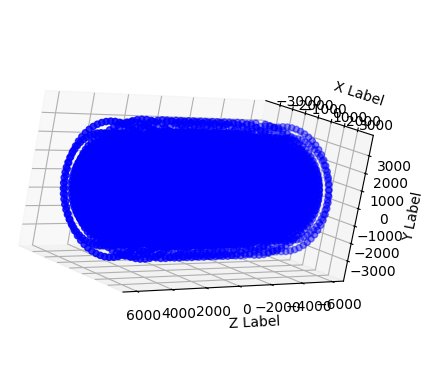

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Open the ROOT files
events = uproot.open("/data/atlas/data/allCellTruthv1/pi0/user.mswiatlo.27153451.OutputStream._000017.root" + ":EventTree")
cell_geo_tree = uproot.open("/data/atlas/data/rho_delta/rho_small.root" + ":CellGeo")

# Find the first event with 8 or more truth particles
min_parts = 5
n_truth_part = events["nTruthPart"].array()
first_index = ak.firsts(ak.where(n_truth_part >= min_parts))
if not ak.is_valid(first_index):
    raise ValueError(f"No event with {min_parts} or more truth particles was found.")
print(f"Event {first_index} has {n_truth_part[first_index]} truth particles.")

# Load data for the specific event
event_data = events.arrays(entry_start=first_index[0], entry_stop=first_index[0] + 1, library="np")
cell_geo_data = cell_geo_tree.arrays(library='np')

# Convert eta, phi to cartesian coordinates
def eta_phi_to_xyz(eta, phi, rPerp):
    theta = 2 * np.arctan(np.exp(-eta))
    return rPerp * np.cos(phi), rPerp * np.sin(phi), rPerp / np.tan(theta)

eta, phi, rPerp = cell_geo_data["cell_geo_eta"][0], cell_geo_data["cell_geo_phi"][0], cell_geo_data["cell_geo_rPerp"][0]
x, y, z = eta_phi_to_xyz(eta, phi, rPerp)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='b')
ax.view_init(elev=45, azim=15, roll=90)
ax.set_box_aspect([1,1,2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
